# What would a music label do? 
***
## Analysis of Pitchfork music album reviews.

Given Pitchfork [music record reviews](https://www.kaggle.com/nolanbconaway/pitchfork-data) written by their journalists in the 18-year period between 1999 and 2016 inclusive, and other resources on musical artists and records:

**What should a music label company do if all they want is an excellent review on Pitchfork?**

1.	How can we predict if an artist will get an excellent review on Pitchfork?  
2.	Can we predict what the review of an artist will be based on reviews of their previous work?

**Client:** music label company.

**Conclusion:** there are seven key recommendations based on the results of this project: see them at the very bottom. Our final accuracy score is ~63%, precision is ~73%. 

## The dataset

The data covers Pitchfork reviews written by their journalists / contributors over the period of January 5, 1999 to January 8, 2017, and totals over 18,000 reviews. 

Data was scraped by Nolan Conaway and uploaded to Kaggle. It was in the format of SQLite database with multiple tables: 
* `artists`
* `content`
* `genres`
* `labels`
* `reviews`
* `years`

### Data dictionary
(compiled from the dataset's Kaggle page)

Field name	| Description |	Format
:---         |     :---      |          :--- 
`reviewid`	| Review unique key	 | Numeric
`artist` |	Name of the recording artist |	String
`author` |	Name of the reviewer |	String
`author_type` |	Reviewer type Staff are given their specific titles while contributors are listed as "Contributor" |	String
`best_new_music` |	Is this title in the category 'Best new music'? <br> Yes: 1 <br> No: 0 |	Numeric
`content` |	Text of the review |	String
`genre` |	Genre of the release |	String
`label` |	Label (publisher) of the release |	String
`pub_date` |	Review publication date |	String
`score` |	Score on a 10-point scale |	Numeric
`title` |	Name of the album |	String
`url` |	Review URL |	String
`year` |	Year of album release. <br> Sometimes Pitchfork reviews albums from the previous year (usually in early January), or from the forthcoming year (usually in December). Likewise, Pitchfork often reviews reissues and lists the original release year along with the reissue year. |	Numeric

### Features I was interested in initially

**Dependent variable:** `score`. Depending on availability of data, I could also try to predict album sales and/or online streaming numbers.

**Independent variables:** `artist`, `author`, `content`, `genre`, `label`, `pub_date`, `title`. 
***

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## 1. Extracting and cleaning the data 

**Step 1.1.** I pulled the data into a dataframe by doing the following:

* joined the SQLite the tables `content`, `genres`, `labels`, `reviews`, `years` on review ID. (The `reviews` table already had info on the artists, so there was no need to join the `artists` table to the rest of the tables.)
* and extracted the data into a dataframe.

In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///database.sqlite')
engine.table_names()

['artists', 'content', 'genres', 'labels', 'reviews', 'years']

In [5]:
# I find syntax for INNER JOIN of multiple tables clunky, so I use an alternative, albeit a little antiquated syntax here
query = 'SELECT c.reviewid AS reviewid_main, * FROM content c, genres g, labels l, reviews r, years y \
        WHERE c.reviewid = g.reviewid AND g.reviewid = l.reviewid AND l.reviewid = r.reviewid AND r.reviewid = y.reviewid' 
with engine.connect() as con:
    result = con.execute(query)
    df = pd.DataFrame(result.fetchall())
    df.columns = result.keys()

In [6]:
df.head()

,reviewid_main,reviewid,content,reviewid,genre,reviewid,label,reviewid,title,artist,...,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,reviewid,year
0,22703,22703,"“Trip-hop” eventually became a ’90s punchline,...",22703,electronic,22703,virgin,22703,mezzanine,massive attack,...,0,nate patrin,contributor,2017-01-08,6,8,1,2017,22703,1998.0
1,22721,22721,"Eight years, five albums, and two EPs in, the ...",22721,metal,22721,hathenter,22721,prelapsarian,krallice,...,0,zoe camp,contributor,2017-01-07,5,7,1,2017,22721,2016.0
2,22659,22659,Minneapolis’ Uranium Club seem to revel in bei...,22659,rock,22659,fashionable idiots,22659,all of them naturals,uranium club,...,0,david glickman,contributor,2017-01-07,5,7,1,2017,22659,2016.0
3,22659,22659,Minneapolis’ Uranium Club seem to revel in bei...,22659,rock,22659,static shock,22659,all of them naturals,uranium club,...,0,david glickman,contributor,2017-01-07,5,7,1,2017,22659,2016.0
4,22661,22661,Kleenex began with a crash. It transpired one ...,22661,rock,22661,kill rock stars,22661,first songs,"kleenex, liliput",...,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,22661,2016.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26018 entries, 0 to 26017
Data columns (total 22 columns):
reviewid_main     26018 non-null int64
reviewid          26018 non-null int64
content           26018 non-null object
reviewid          26018 non-null int64
genre             23317 non-null object
reviewid          26018 non-null int64
label             25977 non-null object
reviewid          26018 non-null int64
title             26018 non-null object
artist            26018 non-null object
url               26018 non-null object
score             26018 non-null float64
best_new_music    26018 non-null int64
author            26018 non-null object
author_type       20340 non-null object
pub_date          26018 non-null object
pub_weekday       26018 non-null int64
pub_day           26018 non-null int64
pub_month         26018 non-null int64
pub_year          26018 non-null int64
reviewid          26018 non-null int64
year              25426 non-null float64
dtypes: float64(2), 

Let's delete `reviewid` columns that duplicate our `reviewid_main` column

In [8]:
df.drop(['reviewid'], axis =1, inplace = True)

**Step 1.2.** Explored the dataset with [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling/blob/master/README.md), and found that there are a number of duplicate entries. Removed the duplicates.

In [11]:
import pandas_profiling
import warnings
pandas_profiling.ProfileReport(df)

Number of variables,17
Number of observations,26018
Total Missing (%),2.0%
Total size in memory,3.4 MiB
Average record size in memory,136.0 B
Numeric,6
Categorical,9
Boolean,1
Date,0
Text (Unique),0
Rejected,1


In [8]:
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25832 entries, 0 to 26017
Data columns (total 17 columns):
reviewid_main     25832 non-null int64
content           25832 non-null object
genre             23224 non-null object
label             25791 non-null object
title             25832 non-null object
artist            25832 non-null object
url               25832 non-null object
score             25832 non-null float64
best_new_music    25832 non-null int64
author            25832 non-null object
author_type       20247 non-null object
pub_date          25832 non-null object
pub_weekday       25832 non-null int64
pub_day           25832 non-null int64
pub_month         25832 non-null int64
pub_year          25832 non-null int64
year              25240 non-null float64
dtypes: float64(2), int64(6), object(9)
memory usage: 3.5+ MB


**Step 1.3.** Did a quick clean-up to make sure there's only one row per review ID in the dataframe. In case more granularity is required, I could pull up the specific tables from SQLite database again, but this will do for now.
    - grouped the entries by review ID and URL
    - and for each such tuple made sure to keep a row that had the most non-null values.

There are 18,389 unique values in column `reviewid_main` and the same number of unique URLs, so that is the final number of entries (i.e. rows) we are looking to achieve. If we remove all rows with duplicative `reviewid_main` and URL values, we may lose some data on the columns that currently contain nulls in some rows. Those are: `label`, `author_type`, and `year`. Let's then keep the rows with the least NULL values.

In [12]:
df_clean1 = (df.groupby(['reviewid_main', 'url'], as_index=False).\
             apply(lambda x: x.loc[x.count(axis=1).idxmax()])).reset_index(drop = True)
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18389 entries, 0 to 18388
Data columns (total 17 columns):
reviewid_main     18389 non-null int64
content           18389 non-null object
genre             16024 non-null object
label             18351 non-null object
title             18389 non-null object
artist            18389 non-null object
url               18389 non-null object
score             18389 non-null float64
best_new_music    18389 non-null int64
author            18389 non-null object
author_type       14485 non-null object
pub_date          18389 non-null object
pub_weekday       18389 non-null int64
pub_day           18389 non-null int64
pub_month         18389 non-null int64
pub_year          18389 non-null int64
year              17983 non-null float64
dtypes: float64(2), int64(6), object(9)
memory usage: 2.4+ MB


Let's see how many non-null values we eliminated, keeping in mind that the 29% of values we eliminated in columns `reviewid_main` and URL were duplicates.

In [13]:
print('Percentage decrease in non-null elements per column')
for col in df.columns:
    print (col+':', "{0:.2f}".format((df[col].count() - df_clean1[col].count())/df[col].count()))

Percentage decrease in non-null elements per column
reviewid_main: 0.29
content: 0.29
genre: 0.31
label: 0.29
title: 0.29
artist: 0.29
url: 0.29
score: 0.29
best_new_music: 0.29
author: 0.29
author_type: 0.29
pub_date: 0.29
pub_weekday: 0.29
pub_day: 0.29
pub_month: 0.29
pub_year: 0.29
year: 0.29


Looks pretty good! We did not eliminate much more than 29% of items per column.
***

## 2. Descriptive and Inferential Statistics on Pitchfork data
**Step 2.1. Basic descriptive statistics and quick observations about Pitchfork review scores**

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import math
from scipy import stats
rcParams['figure.figsize'] = 12, 10

count    18389.000000
mean         7.005715
std          1.293758
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: score, dtype: float64

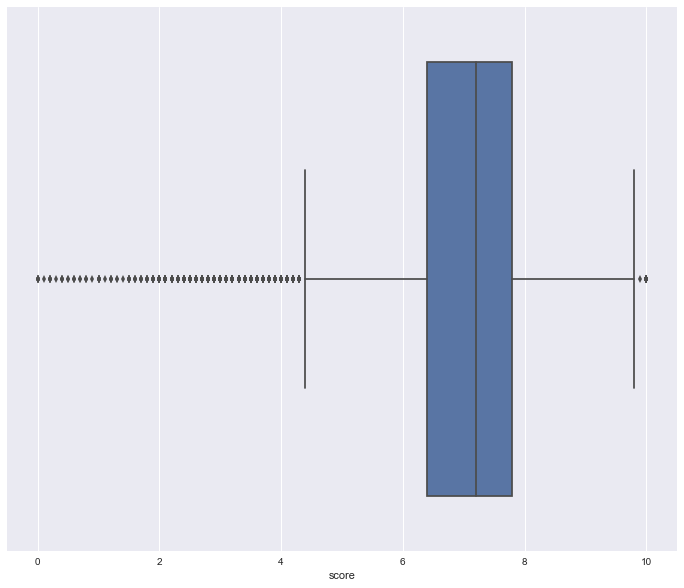

In [20]:
sns.boxplot(df_clean1.score)
df_clean1.score.describe()

Yes, there are albums that received a 0/10 score on Pitchfork! Our dataset has six of those.

In [28]:
pd.set_option('max_colwidth',100)
df_clean1[df_clean1['score']==0.0]

,reviewid_main,content,genre,label,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year
3483,5607,"Travis Morrison got his ass kicked. He tells the whole story here, about the random beatdown he...",pop/r&b,barsuk,travistan,travis morrison,http://pitchfork.com/reviews/albums/5607-travistan/,0.0,0,chris dahlen,None,2004-09-27,0,27,9,2004,2004.0
3914,6255,It could be said that Liz Phair's greatest asset has always been her inability to write a perfec...,rock,capitol,liz phair,liz phair,http://pitchfork.com/reviews/albums/6255-liz-phair/,0.0,0,matt lemay,contributor,2003-06-24,1,24,6,2003,2003.0
3979,6383,"If more drunks would learn from Robert Pollard, simply accept his teachings, alcoholism woul...",rock,rockathon,relaxation of the asshole,robert pollard,http://pitchfork.com/reviews/albums/6383-relaxation-of-the-asshole/,0.0,0,eric carr,contributor,2005-04-20,2,20,4,2005,2005.0
4548,7342,"No, I have not forgotten to put the numbers into the rating spaces above. In over two years\n ...",rock,geffen,nyc ghosts & flowers,sonic youth,http://pitchfork.com/reviews/albums/7342-nyc-ghosts-flowers/,0.0,0,brent dicrescenzo,contributor,2000-04-30,6,30,4,2000,2000.0
6053,9464,,electronic,elektra,shine on,jet,http://pitchfork.com/reviews/albums/9464-shine-on/,0.0,0,ray suzuki,contributor,2006-10-02,0,2,10,2006,2006.0
7119,10571,"\r\n ""Indie's Biggest Hits""? ""Volume 1""? ""NOW that's what I call indie!"" jokes aside, This Is...",None,vice,this is next,various artists,http://pitchfork.com/reviews/albums/10571-this-is-next/,0.0,0,matt lemay,contributor,2007-08-22,2,22,8,2007,2007.0


Example from our table above:

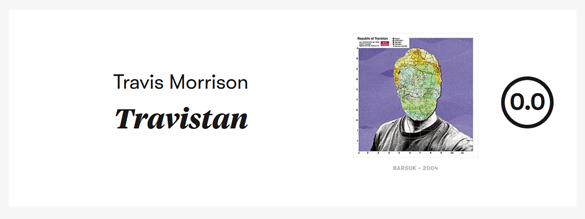

You can check them out for yourself by following the URLs from the table above.

It's very curious that Pitchfork gives a time of day to albums they consider awful, by publishing their reviews on the website. 

**Step 2.2. Inferential Statistics**

*I accepted alpha = .05, but these results would hold up for an alpha that is significanlty lower than that. In fact, the highest p-value I got was ~4.4e-24.*

**Pitchfork tends to give higher review scores to certain music labels.**

In [39]:
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18389 entries, 0 to 18388
Data columns (total 17 columns):
reviewid_main     18389 non-null int64
content           18389 non-null object
genre             16024 non-null object
label             18351 non-null object
title             18389 non-null object
artist            18389 non-null object
url               18389 non-null object
score             18389 non-null float64
best_new_music    18389 non-null int64
author            18389 non-null object
author_type       14485 non-null object
pub_date          18389 non-null object
pub_weekday       18389 non-null int64
pub_day           18389 non-null int64
pub_month         18389 non-null int64
pub_year          18389 non-null int64
year              17983 non-null float64
dtypes: float64(2), int64(6), object(9)
memory usage: 2.4+ MB


In [31]:
all_label_stats = df_clean1.groupby('label', \
                                    as_index = False)['score'].agg({'score': \
                                    ['mean', 'std', 'median', 'count']}).sort_values(by = ('score', 'count'), ascending = False)
all_label_stats.dropna(inplace = True)
thirty_revs_plus = all_label_stats[all_label_stats[('score', 'count')]>=30]
thirty_revs_plus.sort_values(by = ('score', 'mean'), inplace = True, ascending = False)
thirty_revs_plus.head(10)

C:\Users\Dinara\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


label     score                       
                              mean       std median count
1780  light in the attic  7.907018  0.910624   8.00    57
2774           soul jazz  7.886486  0.790275   8.00    37
2175        numero group  7.878333  0.665899   8.00    60
2521               rhino  7.723457  1.583057   8.10    81
3341           young god  7.686667  0.845570   7.85    30
2404       profound lore  7.626667  0.669142   7.70    60
2592          rvng intl.  7.622222  0.716783   7.80    36
1010                 emi  7.563636  1.745815   7.70    77
1758                leaf  7.500000  0.718715   7.80    30
977        editions mego  7.455882  0.805734   7.65    34

In [32]:
thirty_revs_plus.sort_values(by = ('score', 'median'), ascending = False).head(10)

label     score                       
                              mean       std median count
2521               rhino  7.723457  1.583057   8.10    81
1780  light in the attic  7.907018  0.910624   8.00    57
2175        numero group  7.878333  0.665899   8.00    60
2774           soul jazz  7.886486  0.790275   8.00    37
3341           young god  7.686667  0.845570   7.85    30
2592          rvng intl.  7.622222  0.716783   7.80    36
1758                leaf  7.500000  0.718715   7.80    30
2404       profound lore  7.626667  0.669142   7.70    60
1010                 emi  7.563636  1.745815   7.70    77
2992         thirsty ear  7.418182  1.098708   7.70    33

In [36]:
thirty_revs_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 1780 to 1620
Data columns (total 5 columns):
(label, )          115 non-null object
(score, mean)      115 non-null float64
(score, std)       115 non-null float64
(score, median)    115 non-null float64
(score, count)     115 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 5.4+ KB


**The top 10% out of music labels with 30+ reviews, receive statistically significantly higher ratings than the rest of the labels.** These labels are 'rhino', 'light in the attic', 'numero group', 'soul jazz', 'young god', 'rvng intl.', 'leaf', 'profound lore', 'emi', 'thirsty ear', 'editions mego'.

In [38]:
labels_10 = np.array(thirty_revs_plus.sort_values(by = ('score', 'median'), ascending = False).head(len(thirty_revs_plus)//10)['label'])
labels_10

array(['rhino', 'light in the attic', 'numero group', 'soul jazz',
       'young god', 'rvng intl.', 'leaf', 'profound lore', 'emi',
       'thirsty ear', 'editions mego'], dtype=object)

In [40]:
def scores_partition(df, catvar, measurement, catvarvals):
    """Partition the measurements based on the values in the catvar column that are in list catvarvals
    df: dataframe
    catvar: name of categorical variable in the dataframe that is to be checked 
    catvarvals: a list of catvar values on which to partition the rows of dataframe df
    measurement: the name of the continuous variable to be sliced from the partitioned dataframe
    """
    array_1 = np.array(df[df[catvar].isin(catvarvals)][measurement])
    array_2 = np.array(df[-df[catvar].isin(catvarvals)][measurement])
    return array_1, array_2

In [43]:
def two_sample_z(sample1, sample2):
    """Calculate two-sample z-score"""
    return (sample1.mean() - sample2.mean()) / (math.sqrt(sample1.std()**2/len(sample1) + sample2.std()**2/len(sample2)))

In [42]:
top10, other_than_10 = scores_partition(df_clean1, 'label', 'score', labels_10)
len(top10)

535

In [44]:
z_label = two_sample_z(top10, other_than_10)
print("z-score = ", z_label)    
print('p-val = ', stats.norm.sf(z_label)) 

z-score =  13.9805527005
p-val =  1.02445317519e-44


**We observe a similar situation with review authors (various Pitchfork contributors): when we look at top 10 authors by review scores, they turn out to give statistically higher review scores than others.** These authors are 'jenn pelly', 'seth colter walls', 'mark richardson', 'david drake','grayson haver currin', 'philip sherburne', 'andy beta', 'mike powell', 'marc masters', "andy o'connor".

Note that in this case we only considered authors who wrote more than 30 reviews, and who were active in the six months before the data was scraped.

In [45]:
author_stats_wdates = df_clean1.groupby('author', as_index = False)[['score', 'pub_date']].agg({'score': \
                                        ['mean', 'std', 'median', 'count'], 'pub_date': 'max'}).sort_values(by = ('score', \
                                        'count'), ascending = False)
author_30plus_active = author_stats_wdates[(author_stats_wdates[('score','count')]>=30) & \
                                           (author_stats_wdates[('pub_date', 'max')] > '2016-06-08')]
author_30plus_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 398 to 217
Data columns (total 6 columns):
(author, )         40 non-null object
(score, mean)      40 non-null float64
(score, std)       40 non-null float64
(score, median)    40 non-null float64
(score, count)     40 non-null int64
(pub_date, max)    40 non-null object
dtypes: float64(3), int64(1), object(2)
memory usage: 2.2+ KB


If we again went for top 10% of active authors by median score, we would only have four authors. That is very limiting, as it would be hard to have an album reviewed by one of these four, if our results prove to be statistically significant. We instead went for top 10 active authors.

In [46]:
top10_auth_active = np.array(author_30plus_active.sort_values(by = ('score', 'median'), \
                                                              ascending = False).head(10)['author'])
top10_auth_active

array(['jenn pelly', 'seth colter walls', 'mark richardson', 'david drake',
       'grayson haver currin', 'philip sherburne', 'andy beta',
       'mike powell', 'marc masters', "andy o'connor"], dtype=object)

In [47]:
top10_auth_active_scores, other_auth_scores = scores_partition(df_clean1, 'author', 'score', top10_auth_active)
len(top10_auth_active_scores)

1775

In [48]:
z_active_auth = two_sample_z(top10_auth_active_scores, other_auth_scores)
print("z-score = ", z_active_auth)    
print('p-val = ', stats.norm.sf(z_active_auth)) 

z-score =  21.5627115366
p-val =  2.01165308124e-103


**Similar idea for author type: turns out top four author types give statistically significantly higher scores than others.** Those are: 'associate reviews editor', 'executive editor', 'contributing editor', 'senior editor'.

Since 'contributor' is the most common author type, we will assume that for the missing values, the author type is also 'contributor'.

In [50]:
df_clean1['author_type'] = df_clean1['author_type'].fillna('contributor')

In [51]:
author_stats_wdates = df_clean1.groupby('author_type', as_index = False)[['score', 'pub_date']].\
agg({'score': ['mean', 'std', 'median', 'count'], 'pub_date': 'max'}).sort_values(by = ('score', 'median'), \
                                                                                  ascending = False)
author_stats_wdates.head(10)

author_type     score                            pub_date
                                  mean       std median  count         max
3   associate reviews editor  8.056098  0.497015    8.0     41  2017-01-06
11             news director  6.000000  3.021589    7.9      5  2006-01-22
9           executive editor  7.576421  1.257447    7.8    475  2016-12-01
10           managing editor  7.133333  1.607275    7.8      3  2016-08-11
5        contributing editor  7.568571  0.775191    7.7    210  2017-01-02
0           assistant editor  7.531250  0.519896    7.5     16  2016-12-23
8            editor-in-chief  7.065882  1.650581    7.4     85  2007-11-06
12             senior editor  7.075514  1.373789    7.3    486  2016-12-11
6                contributor  6.988428  1.287829    7.2  16324  2017-01-08
7         deputy news editor  7.023000  0.898130    7.2    100  2016-11-09

In [53]:
ordered_author_types = np.array(author_stats_wdates[(author_stats_wdates['score', 'count']>=30) \
                                               & (author_stats_wdates[('pub_date', 'max')] > '2016-06-08')].\
                            sort_values(by = ('score', 'median'), ascending = False)['author_type'])
ordered_author_types

array(['associate reviews editor', 'executive editor',
       'contributing editor', 'senior editor', 'contributor',
       'deputy news editor', 'tracks coordinator', 'associate editor',
       'associate staff writer', 'senior staff writer'], dtype=object)

In [54]:
top_author_types = ordered_author_types[:4]
top_author_types_scores, other_author_types_scores = scores_partition(df_clean1, 'author_type',\
                                                                      'score', top_author_types)
len(top_author_types_scores)

1212

In [55]:
z_author_type = two_sample_z(top_author_types_scores, other_author_types_scores)
print("z-score = ", z_author_type)    
print('p-val = ', stats.norm.sf(z_author_type)) 

z-score =  11.0719275986
p-val =  8.58338643355e-29


**Finally, similar analysis for artists**. Assuming that the label we are working for may represent some of the artists that have already been reviewed by Pitchfork, figuring out which artists tend to get good reviews would be useful.

In [71]:
artist_revnum_score = df_clean1.groupby('artist')['reviewid_main','score'].\
                    agg({'reviewid_main': 'count', 'score': np.median}).sort_values(by = 'reviewid_main', ascending = False)  
artist_revnum_score.head(10)

,reviewid_main,score
artist,,
various artists,687,7.50
guided by voices,23,7.00
the beatles,21,9.30
david bowie,21,8.00
of montreal,20,6.85
mogwai,20,7.10
robert pollard,19,6.20
neil young,19,7.60
the fall,18,7.85


'Various artists' is too vague, so let's not consider it as a candidate for the most favored artists. Let's only consider artists that have received at least three reviews by Pitchfork, who are in the top 10% by median score.

In [82]:
good_artists_candidates = artist_revnum_score[(artist_revnum_score['reviewid_main'] >= 3)].\
                            sort_values(by = 'score', ascending = False).drop('various artists')
good_artists_candidates.head()

,reviewid_main,score
artist,,
john coltrane,3,10.0
neutral milk hotel,3,9.5
t. rex,3,9.5
the velvet underground,7,9.4
the beatles,21,9.3


In [83]:
good_artists_candidates_top10 = good_artists_candidates.head(len(good_artists_candidates)//10)
good_artists_candidates_top10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, john coltrane to the fire show
Data columns (total 2 columns):
reviewid_main    198 non-null int64
score            198 non-null float64
dtypes: float64(1), int64(1)
memory usage: 4.6+ KB


In [87]:
good_artists = list(good_artists_candidates_top10.index)

In [88]:
top10percent_artists_scores, other_artists_scores = scores_partition(df_clean1, 'artist', 'score', good_artists)
len(top10percent_artists_scores)

961

That's not a large number of reviews: it is about top 5% of reviews. Let's expand it to 1/5 of the good artists candidates, instead of the previous 1/10.

In [90]:
good_artists_candidates_top10 = good_artists_candidates.head(len(good_artists_candidates)//5)
good_artists = list(good_artists_candidates_top10.index)
top10percent_artists_scores, other_artists_scores = scores_partition(df_clean1, 'artist', 'score', good_artists)
len(top10percent_artists_scores)

1881

Much better.

In [91]:
z_artist = two_sample_z(top10percent_artists_scores, other_artists_scores)
print("z-score = ", z_artist)    
print('p-val = ', stats.norm.sf(z_artist)) 

z-score =  44.9284381248
p-val =  0.0


So again we see that a group of about 396 artists are statistically significantly more successful on Pitchfork than many others. The list that contains these artists is `good_artists`. Let's take a look at some of those artists:

In [98]:
np.asarray(good_artists)[10:20]

array(['girls', 'prince, the revolution', 'this heat', 'miles davis',
       'sleater-kinney', 'tame impala', 'sly and the family stone',
       'frank ocean', 'otis redding', 'kraftwerk'], 
      dtype='<U32')

## 3. In-depth analysis using Machine Learning

###  Finding out if we can predict if an album would receive a favorable review on Pitchfork, before we pitch it to the magazine.

#### Manipulating features, and feature engineering

From Pandas Profiling Report above we saw that `genre` feature has the cardinality of 9, so we can pretty easily encode that field into numbers by converting it into dummy/indicator variables. To ensure we cover the albums that span several genres, let's go back to the original database to obtain all the data on albums' genres.

In [57]:
genres = pd.read_sql_query("SELECT * FROM genres", engine)
genres.head()

,reviewid,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


In [58]:
dummy_in_genres_df = pd.get_dummies(genres['genre'], prefix = 'genre', drop_first = True)
# append dummy variables for each genre to genres dataframe
genres_w_dummies = genres.join(dummy_in_genres_df)
genres_w_dummies.head()

,reviewid,genre,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock
0,22703,electronic,0,0,0,0,0,0,0,0
1,22721,metal,0,0,0,0,1,0,0,0
2,22659,rock,0,0,0,0,0,0,0,1
3,22661,rock,0,0,0,0,0,0,0,1
4,22725,electronic,0,0,0,0,0,0,0,0


In [59]:
genres_to_merge = genres_w_dummies.drop_duplicates().groupby('reviewid').sum()
genres_to_merge.describe()

,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock
count,18389.000000,18389.000000,18389.000000,18389.000000,18389.000000,18389.000000,18389.000000,18389.000000
mean,0.098700,0.037251,0.011746,0.023655,0.046713,0.077873,0.084779,0.513078
std,0.298267,0.189380,0.107744,0.151977,0.211029,0.267978,0.278560,0.499843
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Dummy variables look good!

In [60]:
genres_to_merge.head()

,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock
reviewid,,,,,,,,
1,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0
10,0,0,0,1,0,0,0,0


In [63]:
df_with_genre_dummies = pd.merge(df_clean1.set_index('reviewid_main'), genres_to_merge, left_index=True, right_index=True)
df_with_genre_dummies.head(2)

,content,genre,label,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock
reviewid_main,,,,,,,,,,,,,,,,,,,,,,,,
1,"Aberfeldy recorded their debut, Young Forever, using a single microphone. Good for them. In th...",rock,rough trade,young forever,aberfeldy,http://pitchfork.com/reviews/albums/1-young-forever/,3.4,0,marc hogan,senior staff writer,2004-08-30,0,30,8,2004,2004.0,0,0,0,0,0,0,0,1
6,Can there be any purpose behind a master's degree in the psychology of music other than inevitab...,electronic,silber,pure tone audiometry,aarktica,http://pitchfork.com/reviews/albums/6-pure-tone-audiometry/,7.4,0,eric carr,contributor,2003-04-08,1,8,4,2003,2003.0,0,0,0,0,0,0,0,0


In [64]:
df_with_genre_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 1 to 22745
Data columns (total 24 columns):
content               18389 non-null object
genre                 16024 non-null object
label                 18351 non-null object
title                 18389 non-null object
artist                18389 non-null object
url                   18389 non-null object
score                 18389 non-null float64
best_new_music        18389 non-null int64
author                18389 non-null object
author_type           18389 non-null object
pub_date              18389 non-null object
pub_weekday           18389 non-null int64
pub_day               18389 non-null int64
pub_month             18389 non-null int64
pub_year              18389 non-null int64
year                  17983 non-null float64
genre_experimental    18389 non-null uint8
genre_folk/country    18389 non-null uint8
genre_global          18389 non-null uint8
genre_jazz            18389 non-null uint8
genre_metal       

If we are looking to predict an album's performance on Pitchfork, we must consider the data we would know about the album at the time of pitching it to Pitchfork. We would only know the following:
* Album title
* Artist
* Music label
* Genre
* Year (i.e. release year)
* _Potentially_ author (i.e. the contributor to whom we will pitch the album)
* _Potentially_ author type (e.g. 'senior editor' or 'senior staff writer')

We already have `genre` and `year` encoded as numbers. <br>
Using the EDA we did in Part 2, we can encode `artist`, `label` (i.e. music label), `author`, and `author type` into numbers based on whether they have proven to be high-scoring before. 
If they belonged to a statistically significantly high-scoring group, we encode their corresponding value as 1, otherwise 0.

Let's initiate a dataframe where we will keep a running result of all our feature engineering efforts: `df_for_feature_engineering`.

In [107]:
df_for_feature_engineering = df_with_genre_dummies.applymap(lambda x: x.strip() if type(x) is str else x)

In [108]:
df_for_feature_engineering['high_sc_artist'] = np.multiply(df_for_feature_engineering['artist'].isin(good_artists),1)
df_for_feature_engineering['high_sc_label'] = np.multiply(df_for_feature_engineering['label'].isin(labels_10), 1)

In [109]:
df_for_feature_engineering['high_sc_author'] = np.multiply(df_for_feature_engineering['author'].isin(top10_auth_active), 1)
df_for_feature_engineering['high_sc_author_type'] = np.multiply(df_for_feature_engineering['author_type'].isin(top_author_types), 1)

In [110]:
df_for_feature_engineering[df_for_feature_engineering['artist'] == 'frank ocean']

,content,genre,label,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock,high_sc_artist,high_sc_label,high_sc_author,high_sc_author_type
reviewid_main,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15172,"Frank Ocean is a 23-year-old New Orleans-born, Beverly Hills-based singer who's in the gleeful...",pop/r&b,self-released,"nostalgia, ultra.",frank ocean,http://pitchfork.com/reviews/albums/15172-nostalgia-ultra/,7.8,0,ryan dombal,senior editor,2011-03-04,4,4,3,2011,2011.0,0,0,0,0,0,1,0,0,1,0,0,1
16859,"Frank Ocean is airborne, looking around, taking it all in. ""Up above the birds, I saw the sky li...",pop/r&b,def jam,channel orange,frank ocean,http://pitchfork.com/reviews/albums/16859-channel-orange/,9.5,1,ryan dombal,senior editor,2012-07-12,3,12,7,2012,2012.0,0,0,0,0,0,1,0,0,1,0,0,1
22295,"At first, Frank Ocean was simply a great storyteller. Then he became the story—an avatar for all...",pop/r&b,self-released,blonde,frank ocean,http://pitchfork.com/reviews/albums/22295-blonde-endless/,9.0,1,ryan dombal,senior editor,2016-08-25,3,25,8,2016,2016.0,0,0,0,0,0,1,0,0,1,0,0,1


We are not doing any analysis on Album Titles just yet. Let's instead work with our numeric variables for now.

In [111]:
df_for_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 1 to 22745
Data columns (total 28 columns):
content                18389 non-null object
genre                  16024 non-null object
label                  18351 non-null object
title                  18389 non-null object
artist                 18389 non-null object
url                    18389 non-null object
score                  18389 non-null float64
best_new_music         18389 non-null int64
author                 18389 non-null object
author_type            18389 non-null object
pub_date               18389 non-null object
pub_weekday            18389 non-null int64
pub_day                18389 non-null int64
pub_month              18389 non-null int64
pub_year               18389 non-null int64
year                   17983 non-null float64
genre_experimental     18389 non-null int64
genre_folk/country     18389 non-null int64
genre_global           18389 non-null int64
genre_jazz             18389 non-null int6

Our feature-engineered looks pretty good. We only need to deal with some missing values in the `year` column, and then we can start trying out a couple of models.

In [114]:
df_for_feature_engineering['year'] = df_for_feature_engineering['year'].astype(int)
df_for_feature_engineering['year'].fillna(df_for_feature_engineering['pub_year'], inplace = True)
df_for_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 1 to 22745
Data columns (total 28 columns):
content                18389 non-null object
genre                  16024 non-null object
label                  18351 non-null object
title                  18389 non-null object
artist                 18389 non-null object
url                    18389 non-null object
score                  18389 non-null float64
best_new_music         18389 non-null int64
author                 18389 non-null object
author_type            18389 non-null object
pub_date               18389 non-null object
pub_weekday            18389 non-null int64
pub_day                18389 non-null int64
pub_month              18389 non-null int64
pub_year               18389 non-null int64
year                   18389 non-null int32
genre_experimental     18389 non-null int64
genre_folk/country     18389 non-null int64
genre_global           18389 non-null int64
genre_jazz             18389 non-null int64


In [116]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_for_num_modeling = df_for_feature_engineering.select_dtypes(include=numerics)

In [432]:
pub_cols = [x for x in df_for_num_modeling.columns if x.startswith('pub')]
df_for_num_modeling.drop(pub_cols, axis = 1, inplace = True)

C:\Users\Dinara\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [433]:
df_for_num_modeling.head()

,score,best_new_music,year,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock,high_sc_artist,high_sc_label,high_sc_author,high_sc_author_type
reviewid_main,,,,,,,,,,,,,,,
1,3.4,0,2004,0,0,0,0,0,0,0,1,0,0,0,0
6,7.4,0,2003,0,0,0,0,0,0,0,0,0,0,0,0
7,8.1,0,2002,0,0,0,0,0,0,0,0,0,0,0,0
8,7.2,0,2005,0,0,0,0,0,0,0,0,0,0,0,0
10,8.0,0,2002,0,0,0,1,0,0,0,0,0,0,0,0


#### Considering Linear Regression modeling

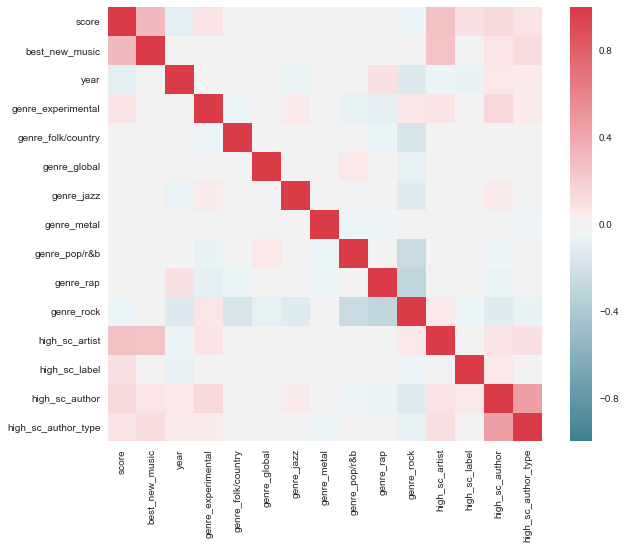

In [434]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_for_num_modeling.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [435]:
import xgboost
from scipy.stats import pearsonr

In [436]:
correlations = {}
for f in df_for_num_modeling.columns:
    x1 = df_for_num_modeling[f].values
    x2 = df_for_num_modeling['score'].values
    key = f + ' vs score'
    correlations[key] = pearsonr(x1,x2)[0]

pd.Series(correlations, index = correlations.keys()).sort_values(ascending = False)

score vs score                  1.000000
best_new_music vs score         0.300245
high_sc_artist vs score         0.261328
high_sc_author vs score         0.126728
high_sc_label vs score          0.090297
genre_experimental vs score     0.084661
high_sc_author_type vs score    0.078990
genre_global vs score           0.036230
genre_jazz vs score             0.035877
genre_folk/country vs score     0.029873
genre_metal vs score           -0.010041
genre_rap vs score             -0.024749
genre_pop/r&b vs score         -0.027385
genre_rock vs score            -0.050763
year vs score                  -0.108497
dtype: float64

We will not know if our album will be considered 'best new music' until we receive the review, so we will disregard that variable for our predictive modeling.

In [437]:
from sklearn.metrics import explained_variance_score, f1_score, accuracy_score
from sklearn.cross_validation import train_test_split

In [438]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [439]:
X_regr, y_regr = df_for_num_modeling[['high_sc_artist', 'high_sc_author', 'year']], df_for_num_modeling[['score']]

X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(X_regr, y_regr, random_state=10, test_size = 0.2)
lin_regr = LinearRegression()
lin_regr.fit(X_train_regr,y_train_regr)
predictions = lin_regr.predict(X_test_regr)
print(predictions[:5])
print(lin_regr.score(X_test_regr, y_test_regr))

[[ 6.82549718]
 [ 6.6943388 ]
 [ 6.93791864]
 [ 6.84423409]
 [ 6.82549718]]
0.0940808341524


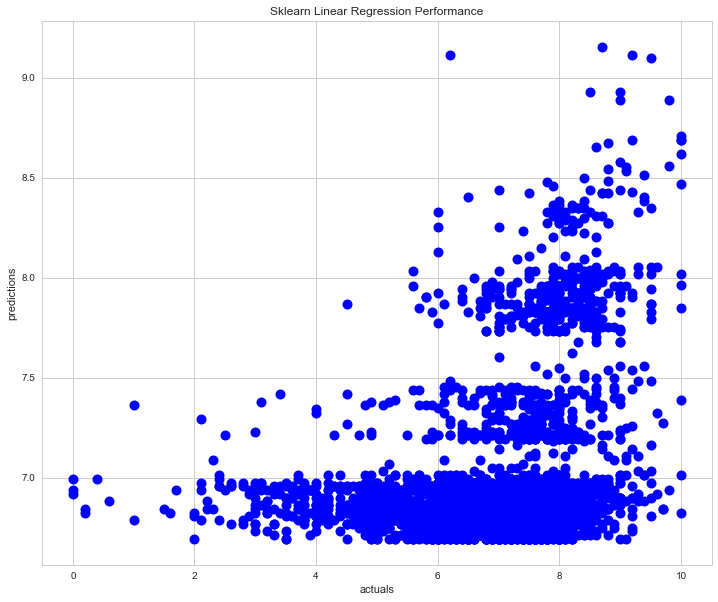

In [440]:
plt.scatter(y_test_regr, predictions, color='blue', linewidth=3)
plt.title('Sklearn Linear Regression Performance')
plt.xlabel('actuals')
plt.ylabel('predictions')
plt.axis('on')
plt.show()

**Trying out Linear Regression with Extreme Gradient Boosting [(XGBoost)](https://xgboost.readthedocs.io/en/latest/model.html)**

In [441]:
xgb_regr = xgboost.XGBRegressor()
xgb_regr.fit(X_train_regr,y_train_regr)
predictions = xgb_regr.predict(X_test_regr)
print(predictions[:5])
print(xgb_regr.score(X_test_regr, y_test_regr))

[ 6.69448996  6.95896149  6.85708141  6.71703815  6.69448996]
0.110386379637


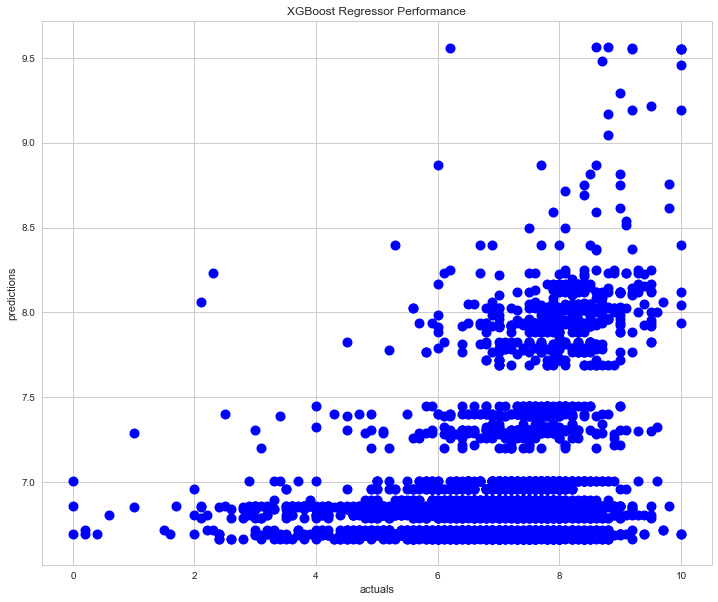

In [442]:
plt.scatter(y_test_regr, predictions, color='blue', linewidth=3)
plt.title('XGBoost Regressor Performance')
plt.xlabel('actuals')
plt.ylabel('predictions')
plt.axis('on')
plt.show()

In [443]:
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV

In [444]:
xgb_model = xgboost.XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.07, 0.08], #so called `eta` value
              'max_depth': [2, 3],
              'min_child_weight': [3, 4],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [100], #number of trees, change it to 1000 for better results
              'seed': [12],
                'reg_alpha': [0.23, 0.25, 0.28]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5,
                   verbose=2, refit=True)

clf.fit(X_train_regr,y_train_regr)

best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('R^2 score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done  72 out of  72 | elapsed:   14.9s finished


R^2 score: 0.1082277984582231
colsample_bytree: 0.7
learning_rate: 0.08
max_depth: 3
min_child_weight: 4
n_estimators: 100
nthread: 4
reg_alpha: 0.23
seed: 12
silent: 1
subsample: 0.8


**After trying out Linear Regression, and searching for the optimal parameters for XGBoost, it is once again clear that trying to solve this problem with Linear Regression, regularized or otherwise, does not work.**

<div class="span5 alert alert-success">

New plan: <br>
1. Find out how to bin scores so that we can basically classify albums as high-scoring, low-scoring, and somewhere in between, say, 'mediocre'.<br>
2. Bin the scores <br>
3. Try building predictive models for score bins as target variable <br>
</div>

**Binning scores**. Based on the fact that Pitchfork considers albums above 8.0 to be outstanding, and anecdotal evidence that albums that get 6.9 are usually nothing to write home about, **let's assume that all albums scoring below 7.0 are low-scoring, those between 7.0 and 7.5 are mediocre, and the rest are high-scoring.**

In [445]:
score_bin = pd.np.digitize(df_for_feature_engineering.score, bins = [0.0, 7.0, 7.5, 10.01])
df_for_feature_engineering['score_bin'] = pd.Series(score_bin, index = df_for_feature_engineering.index)
df_for_feature_engineering.head(3)

,content,genre,label,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock,high_sc_artist,high_sc_label,high_sc_author,high_sc_author_type,score_bin
reviewid_main,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"Aberfeldy recorded their debut, Young Forever, using a single microphone. Good for them. In th...",rock,rough trade,young forever,aberfeldy,http://pitchfork.com/reviews/albums/1-young-forever/,3.4,0,marc hogan,senior staff writer,2004-08-30,0,30,8,2004,2004,0,0,0,0,0,0,0,1,0,0,0,0,1
6,Can there be any purpose behind a master's degree in the psychology of music other than inevitab...,electronic,silber,pure tone audiometry,aarktica,http://pitchfork.com/reviews/albums/6-pure-tone-audiometry/,7.4,0,eric carr,contributor,2003-04-08,1,8,4,2003,2003,0,0,0,0,0,0,0,0,0,0,0,0,2
7,Funny what gets tagged for popular comebacks these days-- post-punk\r\n and electro are the t...,electronic,darla,or you could just go through your whole life and be happy anyway,aarktica,http://pitchfork.com/reviews/albums/7-or-you-could-just-go-through-your-whole-life-and-be-happy-...,8.1,0,christopher dare,contributor,2002-05-16,3,16,5,2002,2002,0,0,0,0,0,0,0,0,0,0,0,0,3


In [446]:
df_for_feature_engineering['score_bin'] = df_for_feature_engineering['score_bin'].apply(lambda x: 0.5 if x == 2 else x//2)
df_for_feature_engineering['score_bin'].value_counts()

1.0    7635
0.0    7165
0.5    3589
Name: score_bin, dtype: int64

**Trying out scikit-learn's logistic regression**

In [447]:
df_for_LR = df_for_feature_engineering.select_dtypes(include=numerics).drop(['score', 'best_new_music'], axis = 1).\
            drop(pub_cols, axis = 1)

In [470]:
df_for_LR_train, df_for_LR_holdout = train_test_split(df_for_LR, test_size = 0.2, random_state = 10)
df_for_LR_train_binary = df_for_LR_train[df_for_LR_train['score_bin'] != 0.5]
X_train = df_for_LR_train_binary.drop(['score_bin'], axis = 1)
y_train = df_for_LR_train_binary['score_bin']

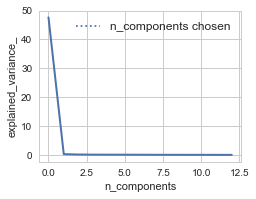

In [471]:
from sklearn import decomposition, linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Plot the PCA spectrum
pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [3, 5, 8, 13]
Cs = np.logspace(-10, 10, 10)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs), cv = 5)
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [472]:
estimator.best_estimator_.named_steps['pca'].n_components

13

In [473]:
estimator.best_score_

0.6402908107194184

In [474]:
y_train = y_train.astype(int)

Let's switch our metric from accuracy to area under ROC curve.

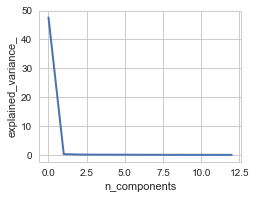

In [475]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

logistic = linear_model.LogisticRegression()

scaler = StandardScaler()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('scaler', scaler),('pca', pca), ('logistic', logistic)])

# Plot the PCA spectrum
pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [3, 5, 8, 13]
Cs = np.logspace(-10, 10, 10)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components, 
                              logistic__C=Cs), scoring = 'roc_auc', cv = 5)
estimator.fit(X_train, y_train)

plt.show()

In [476]:
print("Tuned Logistic Regression Parameters: {}".format(estimator.best_params_)) 
print("Best score is {}".format(estimator.best_score_))

Tuned Logistic Regression Parameters: {'logistic__C': 0.077426368268112777, 'pca__n_components': 13}
Best score is 0.6853959657650239


In [477]:
from sklearn.metrics import accuracy_score, confusion_matrix
df_for_LR_holdout_binary = df_for_LR_holdout[df_for_LR_holdout['score_bin']!=0.5]
X_test = df_for_LR_holdout_binary.drop('score_bin', axis = 1)
y_test = df_for_LR_holdout_binary['score_bin'].astype(int)

In [478]:
n_components = estimator.best_params_['pca__n_components']
C = estimator.best_params_['logistic__C']
pca = decomposition.PCA(n_components = n_components)

# Fit the PCA instance 
pca.fit(X_train)

# Transform the scaled samples: pca_features
pca_features_train = pca.transform(X_train)
pca_features_test = pca.transform(X_test)

model_tune1 = LogisticRegression(C = C)
# Fit the model on the training data.
model_tune1.fit(pca_features_train, y_train)
# Print the accuracy from the testing data.

y_pred = model_tune1.predict(pca_features_test)
print("Accuracy : %.4g" % accuracy_score(y_test, y_pred))
print("Area under ROC curve : %.4g" % roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
      
thresholds = np.logspace(-1, 0, 10)
y_prob = model_tune1.predict_proba(pca_features_test) 

Accuracy : 0.6314
Area under ROC curve : 0.6384
[[1087  321]
 [ 774  789]]


A whole lot of false negatives, and very few true positives are spoiling our picture!

<div class="span5 alert alert-success"><b>Last thing to try:</b> add text-based features. Namely, engineer features based on the album title. </div>

Let's tf-idf vectorize the album title:

In [479]:
df_for_LR_train, df_for_LR_holdout = df_for_LR_train.join(df_for_feature_engineering[['title']]), \
                                df_for_LR_holdout.join(df_for_feature_engineering[['title']])

In [480]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(stop_words='english')
title_tfidf_vectorized_train = vectoriser.fit_transform(df_for_LR_train['title'])
title_tfidf_vectorized_holdout = vectoriser.transform(df_for_LR_holdout['title'])

In [482]:
from sklearn.decomposition import TruncatedSVD

# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components = 50)
reduced_title_features_train = pd.DataFrame(list(svd.fit_transform(title_tfidf_vectorized_train)))
reduced_title_features_holdout = pd.DataFrame(list(svd.fit_transform(title_tfidf_vectorized_holdout)))

In [483]:
df_for_LR_train = pd.concat([df_for_LR_train.reset_index(), reduced_title_features_train], axis = 1)
df_for_LR_train.set_index('reviewid_main', inplace = True)
df_for_LR_train.head()

,year,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock,high_sc_artist,high_sc_label,high_sc_author,high_sc_author_type,score_bin,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
reviewid_main,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12767,2009,0,0,0,0,0,0,0,0,0,0,0,0,0.5,songs about dancing and drugs,8.447751e-03,1.966577e-02,4.221830e-02,-1.078842e-01,3.637609e-01,9.260162e-03,1.182688e-01,-8.268971e-02,1.630566e-02,-5.321540e-02,1.895633e-03,-8.517776e-03,-4.655557e-03,-1.040701e-02,-9.815886e-03,-8.506338e-04,-1.718160e-03,-7.437488e-03,-1.189828e-02,-9.165793e-03,4.900822e-03,-1.001423e-02,-1.236363e-02,-5.132883e-04,-4.832509e-03,-1.717703e-02,-3.943127e-03,-8.968105e-03,1.018836e-02,3.067348e-03,-8.220616e-03,-1.288026e-02,-1.025778e-03,4.308631e-05,3.744893e-03,1.547968e-03,6.859187e-03,5.086291e-03,-3.475831e-03,1.385042e-03,1.590015e-03,1.530504e-03,-6.243141e-03,-1.785871e-03,-7.995964e-03,-1.570880e-03,-7.280132e-03,-1.233480e-02,-8.437295e-03,-8.284612e-04
18235,2013,0,0,0,0,0,0,0,0,0,0,0,0,0.0,jackleg devotional to the heart,2.014086e-03,3.684858e-04,1.268574e-02,1.310511e-03,1.594307e-02,-3.137148e-03,4.262014e-03,-6.464425e-03,-2.185927e-03,-2.178316e-03,3.626523e-03,-1.394789e-03,6.081316e-03,5.769290e-04,-2.695571e-03,-3.937892e-03,-5.331875e-03,-2.342379e-04,5.439445e-03,1.111064e-02,1.115641e-03,2.197690e-02,3.970334e-02,-2.898821e-03,5.611907e-02,-1.445890e-02,2.897409e-02,3.379792e-03,-1.225485e-03,-2.864683e-03,1.650893e-02,9.807302e-02,9.386507e-02,-4.808588e-03,-9.449767e-02,-8.738926e-02,-1.534426e-01,9.325241e-02,1.127397e-01,-8.540473e-02,6.174725e-03,-2.850014e-02,9.317307e-02,-1.730118e-01,-9.653066e-02,4.030015e-02,8.132652e-02,-4.580194e-02,-5.313891e-02,5.489064e-02
7051,1999,1,0,0,0,0,0,0,1,1,0,0,0,0.5,the sebadoh,-1.015310e-12,1.834536e-10,4.160315e-09,-5.113487e-09,1.173793e-08,-3.366839e-09,7.736050e-10,-4.089632e-09,-1.220302e-09,1.479342e-08,1.604613e-09,6.023357e-09,-7.729645e-09,-4.366906e-08,7.044106e-09,-1.657444e-08,-6.628886e-10,6.473407e-09,2.485974e-08,6.214874e-08,-6.490274e-08,-5.120157e-08,3.097417e-08,5.103688e-08,1.762425e-08,4.455249e-08,-5.812178e-08,4.794333e-08,-1.142389e-07,6.637248e-08,1.142351e-07,1.354033e-07,7.319827e-09,1.369181e-07,2.202754e-08,-1.654544e-07,4.859447e-08,4.527495e-07,-8.812846e-08,-1.641504e-07,3.175370e-08,2.845928e-07,-1.129880e-07,-1.011544e-07,1.718400e-07,4.111282e-07,6.987812e-08,-2.670398e-07,-4.774486e-08,-2.589573e-07
420,2003,0,0,0,0,0,0,0,1,0,0,0,0,0.0,dreams of water themes,4.403723e-03,4.415732e-05,4.961798e-03,-5.708460e-03,5.922431e-03,1.697674e-03,-4.267057e-03,1.343485e-03,-1.430635e-03,1.950388e-03,1.307105e-03,7.359469e-03,1.083722e-03,1.448418e-02,-7.465389e-03,3.398110e-03,1.254449e-02,5.078662e-03,2.383103e-02,5.170178e-03,-2.362721e-03,1.245510e-02,4.844548e-02,1.434369e-02,1.704494e-04,2.117032e-02,3.849032e-03,5.976149e-02,4.095144e-02,-1.670230e-02,-1.309610e-02,-2.753099e-02,-8.790093e-03,-6.190678e-04,1.205464e-03,-9.914112e-03,6.564373e-03,-1.766407e-02,1.371901e-02,-1.644613e-02,2.719955e-03,-3.628744e-02,-1.942391e-02,2.354039e-02,2.120379e-03,-7.247644e-03,2.661857e-02,-1.192198e-02,-1.847349e-03,1.125308e-02
10335,2007,0,0,0,1,0,0,0,0,0,0,0,0,1.0,mi sueo,3.413313e-06,5.604829e-07,9.365659e-05,4.957402e-05,2.410323e-05,2.691615e-05,-9.395178e-05,5.279187e-07,-2.540502e-05,-3.517380e-05,1.618750e-05,2.764206e-05,9.687439e-05,8.680905e-06,7.038796e-05,-3.358313e-05,4.571027e-05,4.708169e-05,3.079154e-04,-2.870970e-04,3.126362e-04,2.615434e-04,3.378477e-04,-3.415105e-04,1.425126e-03,-6.336680e-04,-1.301795e-03,1.115475e-03,6.784841e-05,2.014757e-03,6.968106e-04,-1.195704e-04,-1.006876e-03,-2.073107e-04,1.020175e-03,-6.936974e-04,-6.437556e-04,-8.284683e-04,2.167315e-03,-8.720874e-04,1.557061e-03,1.036979e-03,-1.108894e-03,3.860365e-04,1.955163

In [484]:
df_for_LR_holdout = pd.concat([df_for_LR_holdout.reset_index(), reduced_title_features_holdout], axis = 1)
df_for_LR_holdout.set_index('reviewid_main', inplace = True)

In [485]:
X_train = df_for_LR_train[df_for_LR_train['score_bin'] != 0.5].drop(['title', 'score_bin'], axis = 1)
y_train = df_for_LR_train[df_for_LR_train['score_bin'] != 0.5]['score_bin']

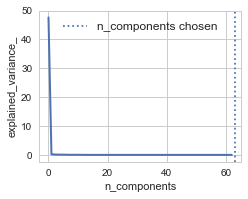

In [486]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

logistic = linear_model.LogisticRegression()

scaler = StandardScaler()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('scaler', scaler),('pca', pca), ('logistic', logistic)])

# Plot the PCA spectrum
pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

n_components = np.append(np.logspace(1, 5, 5, base = 2), 63)
Cs = np.logspace(-5, 5, 5)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs, logistic__penalty = ['l1', 'l2']), cv = 4, scoring = 'roc_auc')
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,\
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [487]:
print("Tuned Logistic Regression Parameters: {}".format(estimator.best_params_)) 
print("Best score is {}".format(estimator.best_score_))

Tuned Logistic Regression Parameters: {'logistic__C': 1.0, 'logistic__penalty': 'l1', 'pca__n_components': 63.0}
Best score is 0.6864528809221904


In [488]:
X_test = df_for_LR_holdout[df_for_LR_holdout['score_bin'] != 0.5].drop(['title', 'score_bin'], axis = 1)
y_test = df_for_LR_holdout[df_for_LR_holdout['score_bin'] != 0.5]['score_bin']

In [489]:
n_components_optimal = estimator.best_params_['pca__n_components']
C_optimal = estimator.best_params_['logistic__C']

pca = decomposition.PCA(n_components = n_components_optimal)

# Fit the PCA instance to the scaled samples
pca_X_train = pca.fit_transform(X_train)

pca_X_test = pca.fit_transform(X_test)

model_tune2 = LogisticRegression(C = C_optimal, penalty = 'l1')
# Fit the model on the training data.
model_tune2.fit(pca_X_train, y_train)

y_pred = model_tune2.predict(pca_X_test)
print("Accuracy : %.4g" % accuracy_score(y_test, y_pred))
print("Area under ROC curve : %.4g" % roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy : 0.619
Area under ROC curve : 0.6238
[[1007  401]
 [ 731  832]]


**The best results we got with scikit-learn's logistic regression: <br>
Accuracy: 0.6314 <br>
ROC AUC: 0.6384** <br>

with hyperparameters: <br>
`C: 0.077426368268112777` <br>
`PCA number of components: 13`


<div class="span5 alert alert-success"><b>Bringing it all together and trying to classify albums using Extreme Gradient Boosting:</b>

In [490]:
from xgboost import XGBClassifier

In [494]:
xgb_classfn_1 = XGBClassifier()
xgb_classfn_1.fit(X_train, y_train)
y_pred_raw = xgb_classfn_1.predict(X_test)
y_pred = [round(value) for value in y_pred_raw]
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

print("Accuracy: %.4f" % (accuracy))
print(confusion_matrix(y_test, y_pred))
print("Area under ROC curve: %.4f" % (roc))

Accuracy: 0.6193
[[1134  274]
 [ 857  706]]
Area under ROC curve: 0.6285


In [495]:
unique, counts = np.unique(y_test, return_counts=True)

print(np.asarray((unique, counts)))

[[  0.00000000e+00   1.00000000e+00]
 [  1.40800000e+03   1.56300000e+03]]


In [496]:
counts[0]/counts.sum()

0.47391450690003367

So our classifiers have been producing results that are just better than random chance, or a naive classifier.

**Let's use GridSearchCV on XGB classifier, and tune the parameters** <br>
For the default runs of the XGB binary classifier, we are using the most common/recommended values for its hyperparameters.

In [519]:
def modelfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds = 100):
    '''This function will allow us to fit and cross-validate our models'''
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgbtrain = xgboost.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgboost.cv(xgb_param, xgbtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval = False)
        alg.set_params(n_estimators=cvresult.shape[0])
        print("n_estimators: %d" %cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predprob))
    print("AUC Score (Test): %f" % roc_auc_score(y_test, dtest_predprob))
    
    rcParams['figure.figsize'] = 12, 10
    
    xgboost.plot_importance(alg, ax=None, height=0.2, xlim=None, ylim=None, \
                             title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', \
                             max_num_features=None, grid=True, show_values=True)


n_estimators: 25

Model Report
Accuracy : 0.6629
AUC Score (Train): 0.735859
AUC Score (Test): 0.673893


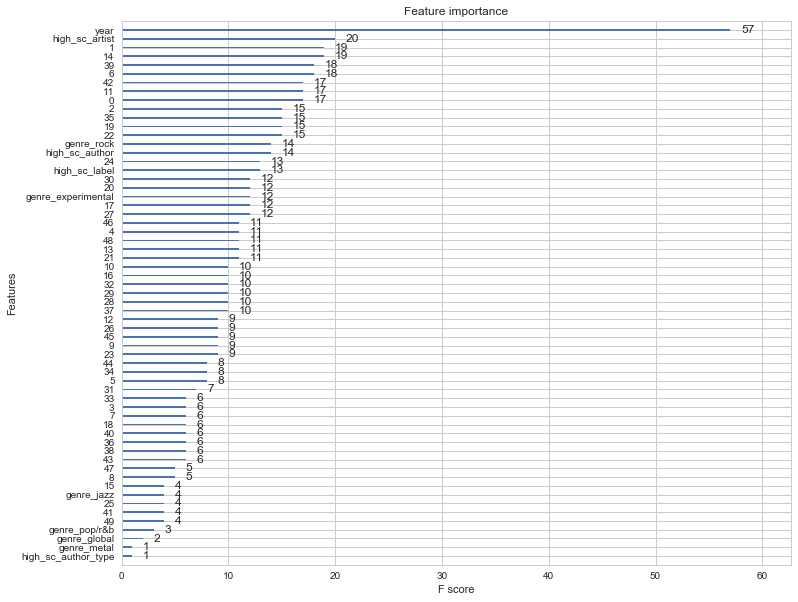

In [530]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, y_train, X_test, y_test)

We use `n_estimators = 25` as identified above. We start by tuning `max_depth` and `min_child_weight`.

In [501]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68460, std: 0.00574, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.68598, std: 0.00646, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.68530, std: 0.00716, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.68474, std: 0.00603, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.68427, std: 0.00575, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.68523, std: 0.00412, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.68002, std: 0.00456, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.68319, std: 0.00759, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.68447, std: 0.00623, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.67442, std: 0.00469, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.67663, std: 0.00512, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.68056, std: 0.00503, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 3

In [502]:
param_test2 = {
 'max_depth': [2, 3, 4],
 'min_child_weight': [2, 3, 4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68057, std: 0.00956, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.68055, std: 0.00957, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.68055, std: 0.00957, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.68551, std: 0.00599, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.68598, std: 0.00646, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.68502, std: 0.00718, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.68539, std: 0.00480, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.68571, std: 0.00503, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.68610, std: 0.00494, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 4, 'min_child_weight': 4},
 0.68610472334571238)

So optimal values for these parameters are `max_depth = 4, min_child_weight = 4`.<br>
Now let's tune `gamma`.

In [506]:
param_test3 = {
 'gamma':[0.1, 0.2, 0.4, 0.8, 1, 1.6]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68612, std: 0.00495, params: {'gamma': 0.1},
  mean: 0.68615, std: 0.00491, params: {'gamma': 0.2},
  mean: 0.68623, std: 0.00497, params: {'gamma': 0.4},
  mean: 0.68639, std: 0.00510, params: {'gamma': 0.8},
  mean: 0.68619, std: 0.00578, params: {'gamma': 1},
  mean: 0.68628, std: 0.00544, params: {'gamma': 1.6}],
 {'gamma': 0.8},
 0.68638979086434726)

In [508]:
param_test4 = {
 'gamma':[i/100.0 for i in range(45,90,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68624, std: 0.00497, params: {'gamma': 0.45},
  mean: 0.68624, std: 0.00497, params: {'gamma': 0.5},
  mean: 0.68624, std: 0.00497, params: {'gamma': 0.55},
  mean: 0.68624, std: 0.00497, params: {'gamma': 0.6},
  mean: 0.68639, std: 0.00509, params: {'gamma': 0.65},
  mean: 0.68639, std: 0.00510, params: {'gamma': 0.7},
  mean: 0.68639, std: 0.00510, params: {'gamma': 0.75},
  mean: 0.68639, std: 0.00510, params: {'gamma': 0.8},
  mean: 0.68639, std: 0.00510, params: {'gamma': 0.85}],
 {'gamma': 0.65},
 0.68639271200005969)

Optimal `gamma is 0.65.`

We rerun our algorithm with the newly found hyperparameters, to find our updated `n_estimators`.

n_estimators: 63

Model Report
Accuracy : 0.6797
AUC Score (Train): 0.755893
AUC Score (Test): 0.677990


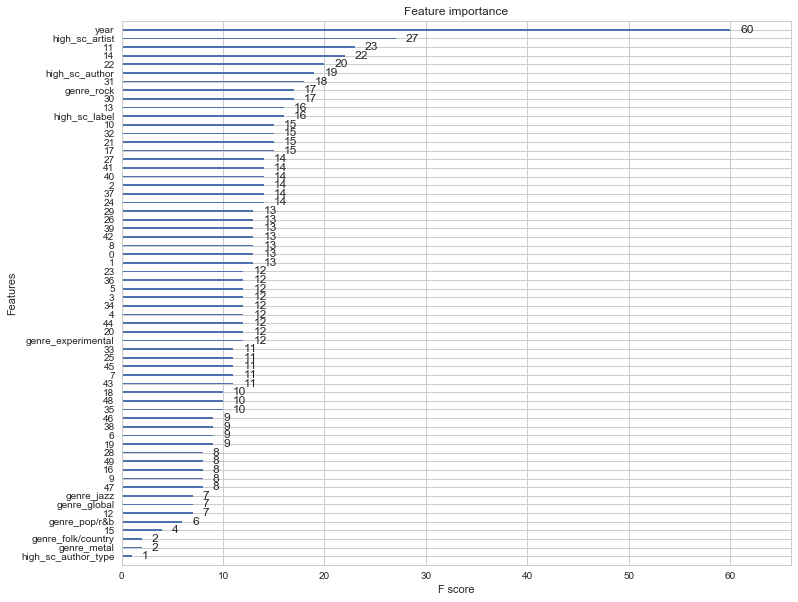

In [509]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=4,
 gamma=0.65,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, X_train, y_train, X_test, y_test)

Tune `subsample` and `colsample_bytree`.

In [510]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=63, max_depth=4,
 min_child_weight=4, gamma=0.65, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68395, std: 0.00559, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.68340, std: 0.00451, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.68435, std: 0.00377, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.68703, std: 0.00436, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.68582, std: 0.00569, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.68505, std: 0.00589, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.68446, std: 0.00355, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.68788, std: 0.00329, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.68318, std: 0.00444, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.68538, std: 0.00632, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.68403, std: 0.00478, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.68765, std: 0.00397, params: {'colsample_bytree': 0.8, 'subsample'

In [513]:
param_test6 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=63, max_depth=4,
 min_child_weight=4, gamma=0.65, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68846, std: 0.00576, params: {'colsample_bytree': 0.85, 'subsample': 0.85},
  mean: 0.68503, std: 0.00477, params: {'colsample_bytree': 0.85, 'subsample': 0.9},
  mean: 0.68831, std: 0.00454, params: {'colsample_bytree': 0.85, 'subsample': 0.95},
  mean: 0.68595, std: 0.00634, params: {'colsample_bytree': 0.9, 'subsample': 0.85},
  mean: 0.68835, std: 0.00531, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: 0.68758, std: 0.00444, params: {'colsample_bytree': 0.9, 'subsample': 0.95},
  mean: 0.68757, std: 0.00562, params: {'colsample_bytree': 0.95, 'subsample': 0.85},
  mean: 0.68736, std: 0.00461, params: {'colsample_bytree': 0.95, 'subsample': 0.9},
  mean: 0.69027, std: 0.00558, params: {'colsample_bytree': 0.95, 'subsample': 0.95}],
 {'colsample_bytree': 0.95, 'subsample': 0.95},
 0.69026826655305185)

Optimal values: `colsample_bytree = 0.95`, `subsample = 0.95`.<br>
Now let's tune regularization parameters `reg_alpha` and `reg_lambda`.

In [514]:
param_test7 = {
 'reg_alpha':[0, 1e-7, 1e-5, 1e-4, 1e-2, 0.1, 1]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=63, max_depth=4,
 min_child_weight=4, gamma=0.65, subsample=0.95, colsample_bytree=0.95,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train, y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.69027, std: 0.00558, params: {'reg_alpha': 0},
  mean: 0.69027, std: 0.00558, params: {'reg_alpha': 1e-07},
  mean: 0.69027, std: 0.00558, params: {'reg_alpha': 1e-05},
  mean: 0.69027, std: 0.00558, params: {'reg_alpha': 0.0001},
  mean: 0.68833, std: 0.00577, params: {'reg_alpha': 0.01},
  mean: 0.68704, std: 0.00511, params: {'reg_alpha': 0.1},
  mean: 0.68705, std: 0.00409, params: {'reg_alpha': 1}],
 {'reg_alpha': 0},
 0.69026826655305185)

In [515]:
param_test8 = {
 'reg_lambda':[1e-4, 1e-2, 0.1, 1, 100]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=63, max_depth=4,
 min_child_weight=4, gamma=0.65, subsample=0.95, colsample_bytree=0.95,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X_train, y_train)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68874, std: 0.00702, params: {'reg_lambda': 0.0001},
  mean: 0.68747, std: 0.00609, params: {'reg_lambda': 0.01},
  mean: 0.68904, std: 0.00607, params: {'reg_lambda': 0.1},
  mean: 0.69027, std: 0.00558, params: {'reg_lambda': 1},
  mean: 0.68722, std: 0.00529, params: {'reg_lambda': 100}],
 {'reg_lambda': 1},
 0.69026826655305185)

In [517]:
param_test9 = {
 'reg_lambda':[0.5, 0.75, 1, 1.5, 2]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=63, max_depth=4,
 min_child_weight=4, gamma=0.65, subsample=0.95, colsample_bytree=0.95,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch9.fit(X_train, y_train)
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68739, std: 0.00656, params: {'reg_lambda': 0.5},
  mean: 0.68791, std: 0.00602, params: {'reg_lambda': 0.75},
  mean: 0.69027, std: 0.00558, params: {'reg_lambda': 1},
  mean: 0.68718, std: 0.00552, params: {'reg_lambda': 1.5},
  mean: 0.68685, std: 0.00701, params: {'reg_lambda': 2}],
 {'reg_lambda': 1},
 0.69026826655305185)

**Parameters so far:** <br>

n_estimators = 63 <br>
max_depth = 4 <br>
min_child_weight = 4 <br>
gamma = 0.65 <br>
colsample_bytree = 0.95 <br>
subsample = 0.95 <br>
reg_alpha = 0 <br>
reg_lambda = 1 

n_estimators: 44

Model Report
Accuracy : 0.6704
AUC Score (Train): 0.738901
AUC Score (Test): 0.673818


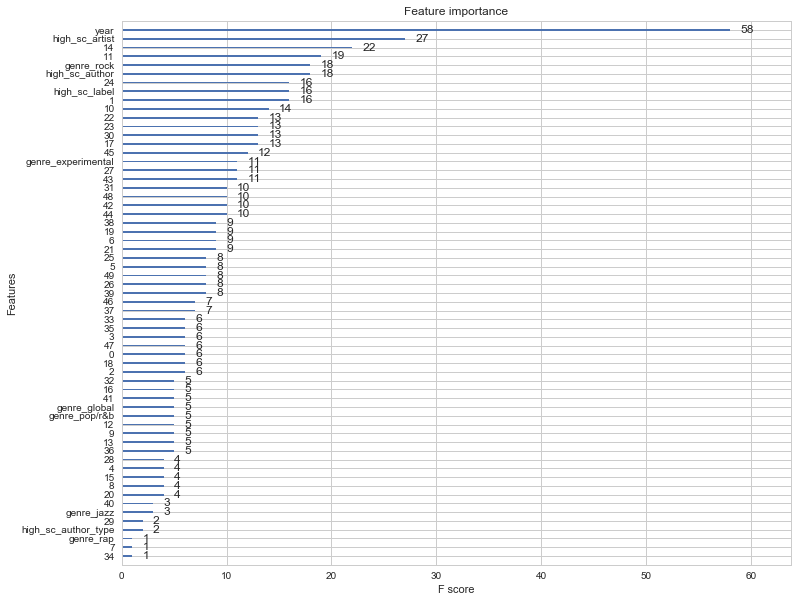

In [520]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=4,
 gamma=0.65,
 subsample=0.95,
 colsample_bytree=0.95,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train, X_test, y_test)

This model is doing worse than our previous try. So let's stick to our previous try:

n_estimators: 63

Model Report
Accuracy : 0.6797
AUC Score (Train): 0.755893
AUC Score (Test): 0.677990


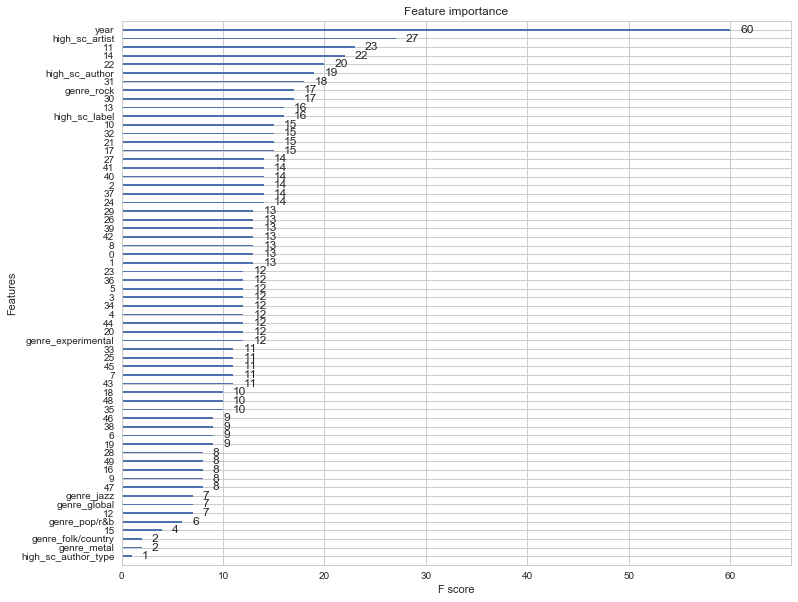

In [522]:
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=4,
 gamma=0.65,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, X_train, y_train, X_test, y_test)

Last step: decrease learning rate, and increase number of estimator trees

n_estimators: 451

Model Report
Accuracy : 0.6695
AUC Score (Train): 0.744746
AUC Score (Test): 0.677050


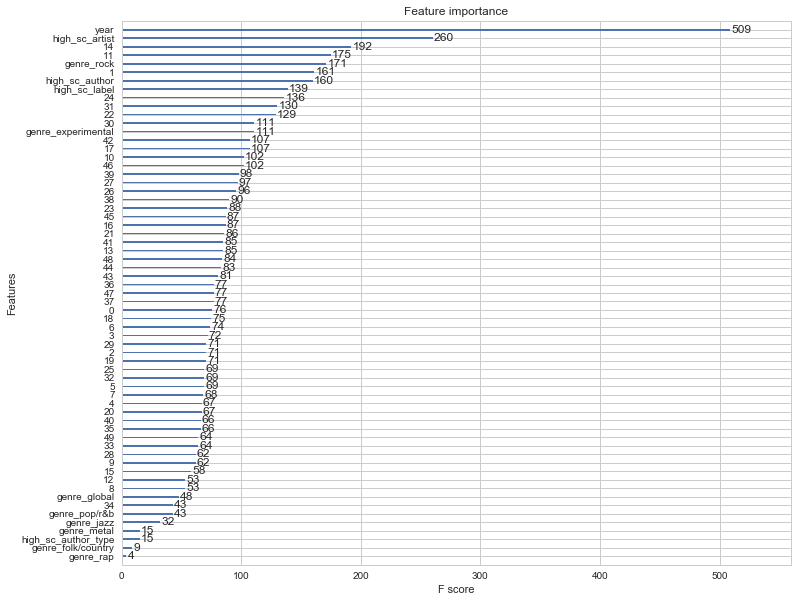

In [527]:
xgb5 = XGBClassifier(
 learning_rate = 0.01,
 n_estimators = 5000,
 max_depth=4,
 min_child_weight=4,
 gamma=0.65,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, X_train, y_train, X_test, y_test)

Again, the technique above did not improve our model. So we stick with `xgb4`

In [558]:
from sklearn.metrics import precision_score, recall_score

In [560]:
y_pred = xgb4.predict(X_test)
y_predprob = xgb4.predict_proba(X_test)[:,1]

print("Accuracy (Test) : %.4g" % accuracy_score(y_test, y_pred))
print("AUC Score (Test): %f" % roc_auc_score(y_test, y_predprob))
print("Precision (Test): %f" % precision_score(y_test, y_pred))
print("Recall (Test): %f" % recall_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy (Test) : 0.6284
AUC Score (Test): 0.677990
Precision (Test): 0.729271
Recall (Test): 0.467051
[[1137  271]
 [ 833  730]]


# Summary of results
    
| Model | Accuracy | ROC AUC
| :---|     -----:|  -----:
| scikit-learn's Logistic Regression | 63.14% | 63.84%
| XGBoost's Classifier |	62.84% | 67.80%


According to our most successful XGBoost Algorithm, the top 10 most important features in vectorized and truncated album titles came under the following indeces:

In [561]:
most_important_words_indeces = [11, 14, 22, 31, 30, 13, 10, 32, 21, 17]

Let's now figure out what these words are:

In [562]:
feature_names = vectoriser.get_feature_names()
best_features = [feature_names[i] for i in svd.components_[0].argsort()[::-1]]
np.take(best_features, [most_important_words_indeces])

array([['black', 'gone', 'fear', 'live', 'phantom', 'years', 'like',
        'pieces', 'late', 'feel']], 
      dtype='<U25')

Most of these words are quite dramatic!

***

<div class="span5 alert alert-info">

<h1> Recommendations </h1>

<p>**Our best model's prediction that an album will receive a high score on Pitchfork (score of 7.5 or more) is correct about 73% of the time, which is better than random chance, but is probably worse than a human's prediction, who has good music taste and a basic understanding of Pitchfork's inclinations. Considering this, take these recommendations with a grain of salt and/or use them for enterntainment purposes only (they _are_ kind of fun though):**</p>

<ol>
<li> As a music label, pitching music that stood the test of time to Pitchfork is a good idea. 
   (The variable `year` is the most important one in our model).
  
<li> Signing artists that have had good track record on Pitchfork is also a good idea.
<li> Then come our top three words used in album titles, that have the biggest correlation with Pitchfork scores: 'black', 'gone', 'fear'.
<li> Having the review written by one of the most 'generous' review-writers is next on the list of most important factors in receiving a high score. We should be aiming at these reviewers: Jenn Pelly, Seth Colter Walls, Mark Richardson, David Drake, Grayson Haver Currin, Philip Sherburne, Andy Beta, Mike Powell, Marc Masters, and Andy O'Connor.
<li> Having the word 'live' in album title.
<li> Album being of rock genre.
<li> Having the words 'phantom' and 'years' in album title.
<ol> 
</div>

**A potential sequel to this project:**

Predicting album's performance on Billboard chart, and connecting Pitchfork performance with Billboard performance.

**Something to do differently next time:**

Do EDA and feature engineering only on training set, then separately on testing/holdout set to avoid contaminating the model as it is being trained.